In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import KFold

In [20]:
df = pd.read_excel('Dados\RJ_Reconstrucao_Moluscos_2024_06_25.xlsx')

<>:1: SyntaxWarning: invalid escape sequence '\R'
<>:1: SyntaxWarning: invalid escape sequence '\R'
C:\Users\Renan\AppData\Local\Temp\ipykernel_12420\2014238134.py:1: SyntaxWarning: invalid escape sequence '\R'
  df = pd.read_excel('Dados\RJ_Reconstrucao_Moluscos_2024_06_25.xlsx')


In [21]:
df.head()

,Ano,Lula_art,Lula_ind,Lula_art_ind,Lula_oceanica_art,Calamar_ind,Polvo_art,Polvo_ind,Polvo_art_ind,Polvo_cabecinha_art,...,Mexilhao_ind,Mexilhao_mangue_art,Caramujo_art,Caramujo_ind,Vieira_ind,Berbigao_art,Vongole_art,Outros_moluscos,TOTAL_MOLLUSCS,TOTAL_GROUPS_F&M
0,1950,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28137.0
1,1951,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27432.0
2,1952,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26648.0
3,1953,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24552.0
4,1954,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22755.0


In [22]:
x0 = df[['Ano', 'Lula_art']].dropna().values
x1 = df[['Ano', 'Lula_ind']].dropna().values

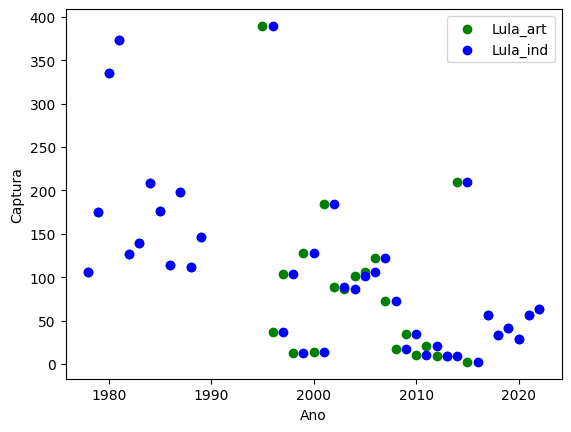

In [23]:
plt.scatter(x0[:, 0], x0[:, 1], c='g', label='Lula_art')
plt.scatter(x1[:,0], x0[:,1], c='b', label= 'Lula_ind')
plt.xlabel('Ano')
plt.ylabel('Captura')
plt.legend()
plt.show()

In [24]:
df_x0= pd.DataFrame(x0, columns= ['Ano', 'Lula_art'])
df_x1=pd.DataFrame(x1, columns= ['Ano', 'Lula_ind'])
df_x0= df_x0.drop_duplicates(subset= 'Lula_art')
df_x1= df_x1.drop_duplicates(subset='Lula_ind')

Normalização Dos dados

In [25]:
x = np.array(df_x0['Ano'], dtype=np.float32).reshape(-1, 1)
y = np.array(df_x0['Lula_art'], dtype=np.float32).reshape(-1, 1)

x_mean = np.mean(x)
x_std = np.std(x)
x_normalized = (x - x_mean) / x_std

y_mean = np.mean(y)
y_std = np.std(y)
y_normalized = (y - y_mean) / y_std

In [26]:
def leaky_relu(x):
    return tf.nn.RMSprop(x, alpha=0.01)

In [17]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(1, activation='leaky_relu', input_shape=(1,)),
    tf.keras.layers.Dense(32, activation='leaky_relu'),
    tf.keras.layers.Dense(64, activation='leaky_relu'),
    tf.keras.layers.Dense(128, activation='leaky_relu'),
    tf.keras.layers.Dense(64, activation='leaky_relu'),
    tf.keras.layers.Dense(32, activation='leaky_relu'),
    tf.keras.layers.Dense(1, activation='leaky_relu')
    
])

opt = tf.keras.optimizers.RMSprop(learning_rate=0.001)
model.compile(optimizer=opt, loss='mse', metrics=['mse'])

print_every_100_epochs = PrintEveryNEpochs(N=100) 

history = model.fit(
    x_normalized, y_normalized, 
    epochs=1000, 
    batch_size=12, 
    steps_per_epoch=50, 
    verbose=0,  
    callbacks=[print_every_100_epochs]
)
x_all = np.arange(min(x.flatten()), max(x.flatten()) + 1).reshape(-1, 1)
x_all_normalized = (x_all - x_mean) / x_std
y_all_predicted_normalized = model.predict(x_all_normalized)
y_all_predicted = y_all_predicted_normalized * y_std + y_mean

df_predicted = pd.DataFrame({'Ano': x.flatten(), 'Captura Original': y.flatten()})
df_all_predicted = pd.DataFrame({'Ano': x_all.flatten(), 'Captura Preditos': y_all_predicted.flatten()})
df_combined = pd.merge(df_predicted, df_all_predicted, on='Ano', how='right').sort_values(by='Ano')

plt.scatter(df_combined['Ano'], df_combined['Captura Original'], color='blue', label='Dados originais')
plt.plot(df_combined['Ano'], df_combined['Captura Preditos'], color='red', label='Predição')
plt.xlabel('Ano')
plt.ylabel('Captura')
plt.title('Treinamento Lula Industrial')
plt.legend()
plt.show()

loss_values = history.history['loss']
#accuracy_values = history.history['accuracy']
epochs = range(1, len(loss_values) + 1)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, loss_values, 'b')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.title('Loss ao longo das épocas')
plt.show()

In [30]:

anos_para_prever = np.array([1990, 1991, 1992, 1993, 1994, 2016]).reshape(-1, 1)

anos_para_prever_normalizados = (anos_para_prever - x_mean) / x_std

predicoes_normalizadas = model.predict(anos_para_prever_normalizados)

predicoes = predicoes_normalizadas * y_std + y_mean


for ano, predicao in zip(anos_para_prever.flatten(), predicoes.flatten()):
    print(f"Predição para o ano {ano}: {predicao}")


df_predicted = pd.DataFrame({'Ano': x.flatten(), 'Captura Original': y.flatten()})
df_all_predicted = pd.DataFrame({'Ano': x_all.flatten(), 'Captura Preditos': y_all_predicted.flatten()})
df_combined = pd.merge(df_predicted, df_all_predicted, on='Ano', how='right').sort_values(by='Ano')
df_anos_para_prever = pd.DataFrame({'Ano': anos_para_prever.flatten(), 'Captura Preditos': predicoes.flatten()})
df_combined = pd.concat([df_combined, df_anos_para_prever]).drop_duplicates().sort_values(by='Ano')


plt.scatter(df_combined['Ano'], df_combined['Captura Original'], color='blue', label='Dados originais')
plt.plot(df_combined['Ano'], df_combined['Captura Preditos'], color='red', label='Curva de Predição')
plt.scatter(df_anos_para_prever['Ano'], df_anos_para_prever['Captura Preditos'], color='green', label='Previsões', zorder=5)
plt.xlabel('Ano')
plt.ylabel('Captura')
plt.title('Predição Lula Artesanal')
plt.legend()
plt.show()


loss_values = history.history['loss']
epochs = range(1, len(loss_values) + 1)

plt.figure(figsize=(12, 6))
plt.plot(epochs, loss_values, 'b')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.title('Loss ao longo das épocas')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
Predição para o ano 1990: 151.9309539794922
Predição para o ano 1991: 202.35134887695312
Predição para o ano 1992: 245.20587158203125
Predição para o ano 1993: 282.9792175292969
Predição para o ano 1994: 313.49554443359375
Predição para o ano 2016: 46.597633361816406


NameError: name 'x_all' is not defined

In [16]:
df_originais = pd.DataFrame({'Ano': x.flatten(), 'Captura Original': y.flatten()})
df_preditos = pd.DataFrame({'Ano': anos_para_prever.flatten(), 'Captura Preditos': predicoes.flatten()})
df_combined = pd.merge(df_originais, df_preditos, on='Ano', how='outer').sort_values(by='Ano')
print(df_combined)
df_combined.to_excel('Lula_artesanal_reconstruido.xlsx', index=False)

       Ano  Captura Original  Captura Preditos
0   1978.0        106.000000               NaN
1   1979.0        175.000000               NaN
2   1980.0        335.000000               NaN
3   1981.0        373.000000               NaN
4   1982.0        127.000000               NaN
5   1983.0        140.000000               NaN
6   1984.0        209.000000               NaN
7   1985.0        176.000000               NaN
8   1986.0        114.000000               NaN
9   1987.0        198.000000               NaN
10  1988.0        112.000000               NaN
11  1989.0        146.000000               NaN
12  1990.0               NaN        153.981415
13  1991.0               NaN        198.208771
14  1992.0               NaN        250.995804
15  1993.0               NaN        307.264069
16  1994.0               NaN        358.653687
17  1995.0        389.500000               NaN
18  1996.0         36.500000               NaN
19  1997.0        104.000000               NaN
20  1998.0   

LULA INDUSTRIAL

In [17]:
x = np.array(df_x1['Ano'], dtype=np.float32).reshape(-1, 1)
y = np.array(df_x1['Lula_ind'], dtype=np.float32).reshape(-1, 1)

x_mean = np.mean(x)
x_std = np.std(x)
x_normalized = (x - x_mean) / x_std

y_mean = np.mean(y)
y_std = np.std(y)
y_normalized = (y - y_mean) / y_std

C:\Users\Renan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.12_3.12.1264.0_x64__qbz5n2kfra8p0\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


Epoch 100: loss = 0.2204141616821289
Epoch 200: loss = 0.13614842295646667
Epoch 300: loss = 0.15976500511169434
Epoch 400: loss = 0.11780454963445663
Epoch 500: loss = 0.08592069149017334
Epoch 600: loss = 0.17601676285266876
Epoch 700: loss = 0.1573607474565506
Epoch 800: loss = 0.03852381557226181
Epoch 900: loss = 0.05357667803764343
Epoch 1000: loss = 0.04463030770421028
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


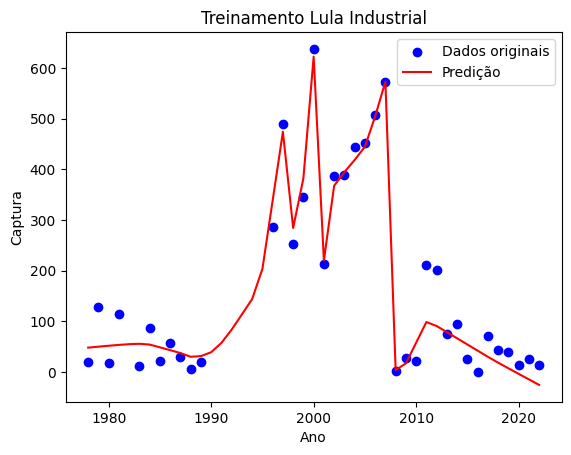

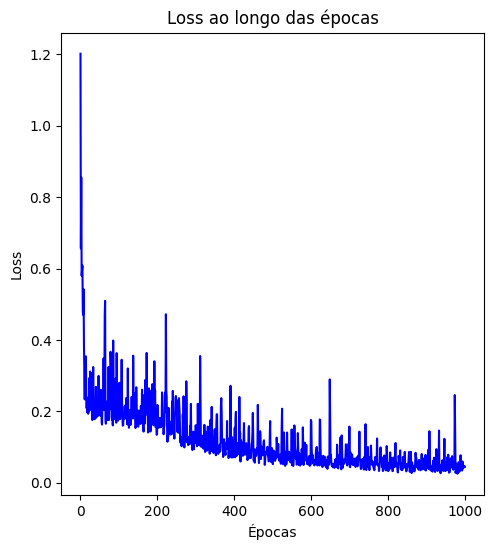

In [18]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(1, activation='leaky_relu', input_shape=(1,)),
    tf.keras.layers.Dense(32, activation='leaky_relu'),
    tf.keras.layers.Dense(64, activation='leaky_relu'),
    tf.keras.layers.Dense(128, activation='leaky_relu'),
    tf.keras.layers.Dense(64, activation='leaky_relu'),
    tf.keras.layers.Dense(32, activation='leaky_relu'),
    tf.keras.layers.Dense(1, activation='leaky_relu')
    
])

opt = tf.keras.optimizers.RMSprop(learning_rate=0.001)
model.compile(optimizer=opt, loss='mse', metrics=['mse'])

print_every_100_epochs = PrintEveryNEpochs(N=100) 

history = model.fit(
    x_normalized, y_normalized, 
    epochs=1000, 
    batch_size=12, 
    steps_per_epoch=50, 
    verbose=0,  
    callbacks=[print_every_100_epochs]
)
x_all = np.arange(min(x.flatten()), max(x.flatten()) + 1).reshape(-1, 1)
x_all_normalized = (x_all - x_mean) / x_std
y_all_predicted_normalized = model.predict(x_all_normalized)
y_all_predicted = y_all_predicted_normalized * y_std + y_mean

df_predicted = pd.DataFrame({'Ano': x.flatten(), 'Captura Original': y.flatten()})
df_all_predicted = pd.DataFrame({'Ano': x_all.flatten(), 'Captura Preditos': y_all_predicted.flatten()})
df_combined = pd.merge(df_predicted, df_all_predicted, on='Ano', how='right').sort_values(by='Ano')

plt.scatter(df_combined['Ano'], df_combined['Captura Original'], color='blue', label='Dados originais')
plt.plot(df_combined['Ano'], df_combined['Captura Preditos'], color='red', label='Predição')
plt.xlabel('Ano')
plt.ylabel('Captura')
plt.title('Treinamento Lula Industrial')
plt.legend()
plt.show()

loss_values = history.history['loss']
#accuracy_values = history.history['accuracy']
epochs = range(1, len(loss_values) + 1)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, loss_values, 'b')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.title('Loss ao longo das épocas')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Predição para o ano 1990: 39.33856201171875
Predição para o ano 1991: 57.732025146484375
Predição para o ano 1992: 83.9717025756836
Predição para o ano 1993: 113.88688659667969
Predição para o ano 1994: 144.27792358398438


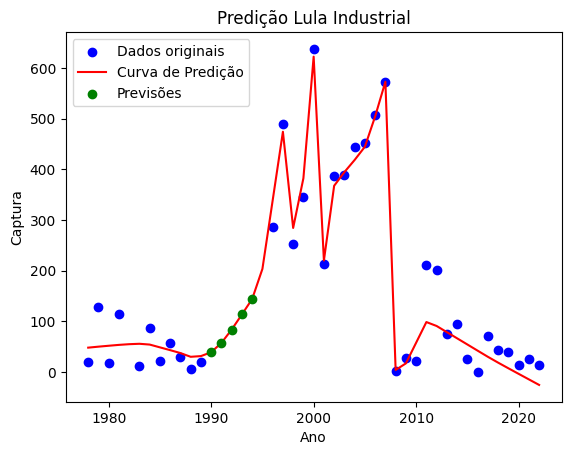

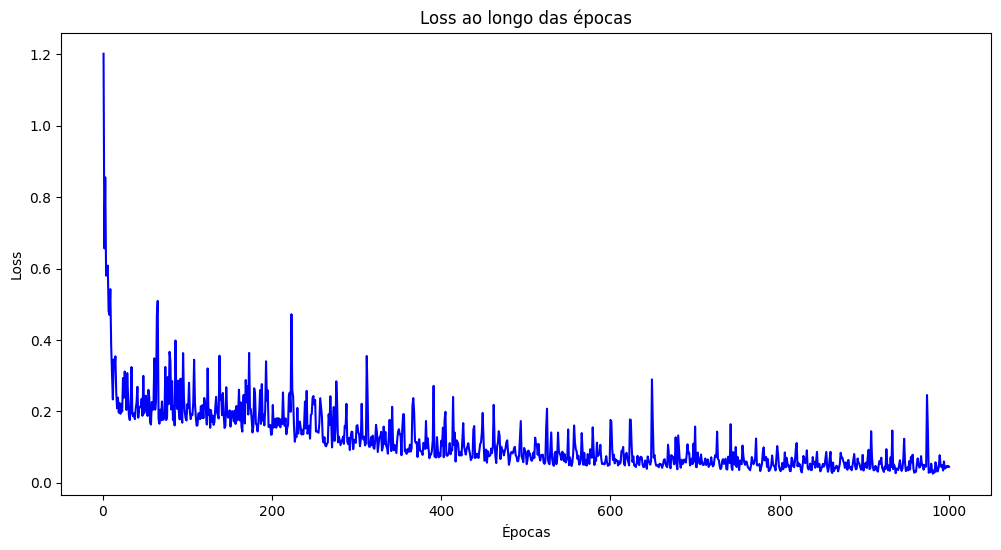

In [20]:
anos_para_prever = np.array([1990, 1991, 1992, 1993, 1994]).reshape(-1, 1)
anos_para_prever_normalizados = (anos_para_prever - x_mean) / x_std
predicoes_normalizadas = model.predict(anos_para_prever_normalizados)
predicoes = predicoes_normalizadas * y_std + y_mean

for ano, predicao in zip(anos_para_prever.flatten(), predicoes.flatten()):
    print(f"Predição para o ano {ano}: {predicao}")


df_predicted = pd.DataFrame({'Ano': x.flatten(), 'Captura Original': y.flatten()})
df_all_predicted = pd.DataFrame({'Ano': x_all.flatten(), 'Captura Preditos': y_all_predicted.flatten()})
df_combined = pd.merge(df_predicted, df_all_predicted, on='Ano', how='right').sort_values(by='Ano')
df_anos_para_prever = pd.DataFrame({'Ano': anos_para_prever.flatten(), 'Captura Preditos': predicoes.flatten()})
df_combined = pd.concat([df_combined, df_anos_para_prever]).drop_duplicates().sort_values(by='Ano')


plt.scatter(df_combined['Ano'], df_combined['Captura Original'], color='blue', label='Dados originais')
plt.plot(df_combined['Ano'], df_combined['Captura Preditos'], color='red', label='Curva de Predição')
plt.scatter(df_anos_para_prever['Ano'], df_anos_para_prever['Captura Preditos'], color='green', label='Previsões', zorder=5)
plt.xlabel('Ano')
plt.ylabel('Captura')
plt.title('Predição Lula Industrial')
plt.legend()
plt.show()


loss_values = history.history['loss']
epochs = range(1, len(loss_values) + 1)

plt.figure(figsize=(12, 6))
plt.plot(epochs, loss_values, 'b')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.title('Loss ao longo das épocas')
plt.show()

In [21]:
df_originais = pd.DataFrame({'Ano': x.flatten(), 'Captura Original': y.flatten()})
df_preditos = pd.DataFrame({'Ano': anos_para_prever.flatten(), 'Captura Preditos': predicoes.flatten()})
df_combined = pd.merge(df_originais, df_preditos, on='Ano', how='outer').sort_values(by='Ano')
print(df_combined)
df_combined.to_excel('Lula_industrial_reconstruido.xlsx', index=False)

       Ano  Captura Original  Captura Preditos
0   1978.0         20.000000               NaN
1   1979.0        129.000000               NaN
2   1980.0         18.000000               NaN
3   1981.0        115.000000               NaN
4   1983.0         12.000000               NaN
5   1984.0         87.000000               NaN
6   1985.0         23.000000               NaN
7   1986.0         57.000000               NaN
8   1987.0         30.000000               NaN
9   1988.0          6.000000               NaN
10  1989.0         21.000000               NaN
11  1990.0               NaN         39.338562
12  1991.0               NaN         57.732025
13  1992.0               NaN         83.971703
14  1993.0               NaN        113.886887
15  1994.0               NaN        144.277924
16  1996.0        286.000000               NaN
17  1997.0        488.500000               NaN
18  1998.0        252.500000               NaN
19  1999.0        345.500000               NaN
20  2000.0   

LULA TOTAL

In [22]:
df_1 = pd.read_excel('DataFrame_reconstruido\Lula_artesanal_reconstruido.xlsx')

<>:1: SyntaxWarning: invalid escape sequence '\L'
<>:1: SyntaxWarning: invalid escape sequence '\L'
C:\Users\Renan\AppData\Local\Temp\ipykernel_23328\249233856.py:1: SyntaxWarning: invalid escape sequence '\L'
  df_1 = pd.read_excel('DataFrame_reconstruido\Lula_artesanal_reconstruido.xlsx')


In [23]:
x0 = pd.DataFrame(df_1[['Ano', 'Captura Original']].fillna(0).values, columns=['Ano', 'Captura Original'])
x1 = pd.DataFrame(df_1[['Ano', 'Captura Preditos']].fillna(0).values, columns=['Ano', 'Captura Preditos'])

In [24]:
resultado = x0['Captura Original'] + x1['Captura Preditos']

novo_df1 = pd.DataFrame({'Ano': df_1['Ano'], 'Lula_art': resultado})

print(novo_df1)

     Ano    Lula_art
0   1978  106.000000
1   1979  175.000000
2   1980  335.000000
3   1981  373.000000
4   1982  127.000000
5   1983  140.000000
6   1984  209.000000
7   1985  176.000000
8   1986  114.000000
9   1987  198.000000
10  1988  112.000000
11  1989  146.000000
12  1990  153.981415
13  1991  198.208771
14  1992  250.995804
15  1993  307.264069
16  1994  358.653687
17  1995  389.500000
18  1996   36.500000
19  1997  104.000000
20  1998   12.500000
21  1999  127.500000
22  2000   14.000000
23  2001  184.500000
24  2002   88.500000
25  2003   86.500000
26  2004  101.000000
27  2005  106.500000
28  2006  122.500000
29  2007   72.500000
30  2008   17.559999
31  2009   34.530201
32  2010   10.680000
33  2011   20.593000
34  2012    8.878000
35  2013    9.596000
36  2014  209.839005
37  2015    2.517000
38  2016   50.300564
39  2017   56.960030
40  2018   33.903400
41  2019   41.963600
42  2020   29.422100
43  2021   56.820000
44  2022   63.434299


In [25]:
df_2 = pd.read_excel('DataFrame_reconstruido\Lula_industrial_reconstruido.xlsx')

<>:1: SyntaxWarning: invalid escape sequence '\L'
<>:1: SyntaxWarning: invalid escape sequence '\L'
C:\Users\Renan\AppData\Local\Temp\ipykernel_23328\1443897365.py:1: SyntaxWarning: invalid escape sequence '\L'
  df_2 = pd.read_excel('DataFrame_reconstruido\Lula_industrial_reconstruido.xlsx')


In [26]:
x2 = pd.DataFrame(df_2[['Ano', 'Captura Original']].fillna(0).values, columns=['Ano', 'Captura Original'])
x3 = pd.DataFrame(df_2[['Ano', 'Captura Preditos']].fillna(0).values, columns=['Ano', 'Captura Preditos'])

In [27]:
resultado_2 = x2['Captura Original'] + x3['Captura Preditos']

novo_df_2 = pd.DataFrame({'Ano': df_2['Ano'], 'Lula_ind': resultado_2})

print(novo_df_2)

     Ano    Lula_ind
0   1978   20.000000
1   1979  129.000000
2   1980   18.000000
3   1981  115.000000
4   1983   12.000000
5   1984   87.000000
6   1985   23.000000
7   1986   57.000000
8   1987   30.000000
9   1988    6.000000
10  1989   21.000000
11  1990   39.338562
12  1991   57.732025
13  1992   83.971703
14  1993  113.886887
15  1994  144.277924
16  1996  286.000000
17  1997  488.500000
18  1998  252.500000
19  1999  345.500000
20  2000  637.500000
21  2001  214.000000
22  2002  387.500000
23  2003  389.500000
24  2004  444.000000
25  2005  451.500000
26  2006  507.500000
27  2007  572.500000
28  2008    2.167000
29  2009   28.509001
30  2010   22.627001
31  2011  210.690994
32  2012  201.509995
33  2013   76.178001
34  2014   94.943001
35  2015   25.068001
36  2016    0.023000
37  2017   70.802971
38  2018   44.520100
39  2019   38.862202
40  2020   13.996800
41  2021   25.391800
42  2022   13.432000


In [28]:
resultado = x0['Captura Original'] + x1['Captura Preditos'] + x2['Captura Original'] + x3['Captura Preditos']

lula_total = pd.DataFrame({'Ano': df_1['Ano'], 'Lula_total': resultado}).dropna()

print(lula_total)

     Ano  Lula_total
0   1978  126.000000
1   1979  304.000000
2   1980  353.000000
3   1981  488.000000
4   1982  139.000000
5   1983  227.000000
6   1984  232.000000
7   1985  233.000000
8   1986  144.000000
9   1987  204.000000
10  1988  133.000000
11  1989  185.338562
12  1990  211.713440
13  1991  282.180473
14  1992  364.882690
15  1993  451.541992
16  1994  644.653687
17  1995  878.000000
18  1996  289.000000
19  1997  449.500000
20  1998  650.000000
21  1999  341.500000
22  2000  401.500000
23  2001  574.000000
24  2002  532.500000
25  2003  538.000000
26  2004  608.500000
27  2005  679.000000
28  2006  124.667000
29  2007  101.009001
30  2008   40.187000
31  2009  245.221195
32  2010  212.189995
33  2011   96.771002
34  2012  103.821001
35  2013   34.664001
36  2014  209.862005
37  2015   73.319971
38  2016   94.820663
39  2017   95.822231
40  2018   47.900201
41  2019   67.355400
42  2020   42.854100


In [29]:
x = np.array(lula_total['Ano'], dtype=np.float32).reshape(-1, 1)
y = np.array(lula_total['Lula_total'], dtype=np.float32).reshape(-1, 1)

x_mean = np.mean(x)
x_std = np.std(x)
x_normalized = (x - x_mean) / x_std

y_mean = np.mean(y)
y_std = np.std(y)
y_normalized = (y - y_mean) / y_std

C:\Users\Renan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.12_3.12.1264.0_x64__qbz5n2kfra8p0\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


Epoch 100: loss = 0.29466813802719116
Epoch 200: loss = 0.25245872139930725
Epoch 300: loss = 0.2635357677936554
Epoch 400: loss = 0.19380387663841248
Epoch 500: loss = 0.21877369284629822
Epoch 600: loss = 0.10780717432498932
Epoch 700: loss = 0.12263371795415878
Epoch 800: loss = 0.1158146858215332
Epoch 900: loss = 0.09871691465377808
Epoch 1000: loss = 0.10325691848993301
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


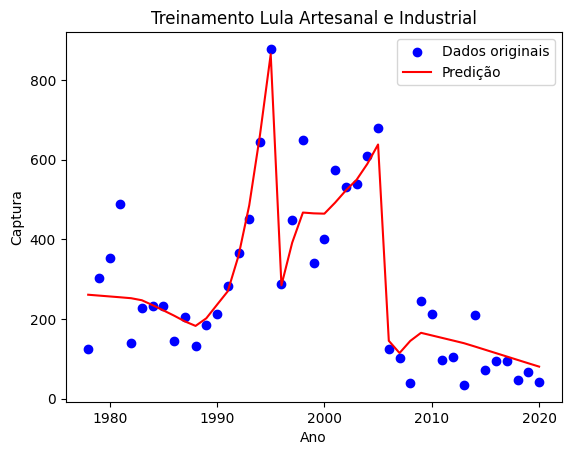

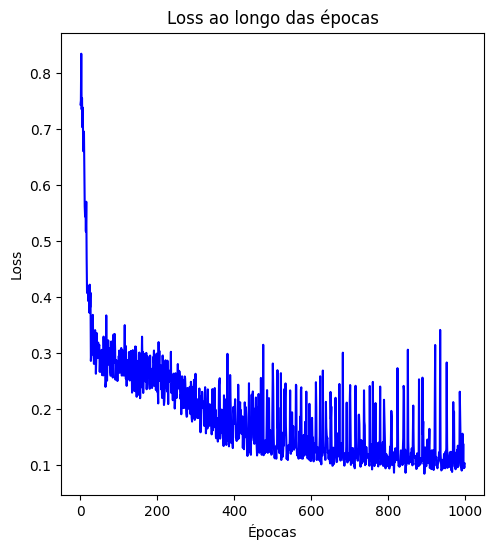

In [33]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(1, activation='leaky_relu', input_shape=(1,)),
    tf.keras.layers.Dense(32, activation='leaky_relu'),
    tf.keras.layers.Dense(64, activation='leaky_relu'),
    tf.keras.layers.Dense(128, activation='leaky_relu'),
    tf.keras.layers.Dense(64, activation='leaky_relu'),
    tf.keras.layers.Dense(32, activation='leaky_relu'),
    tf.keras.layers.Dense(1, activation='leaky_relu')
    
])

opt = tf.keras.optimizers.RMSprop(learning_rate=0.001)
model.compile(optimizer=opt, loss='mse', metrics=['mse'])

print_every_100_epochs = PrintEveryNEpochs(N=100) 

history = model.fit(
    x_normalized, y_normalized, 
    epochs=1000, 
    batch_size=12, 
    steps_per_epoch=50, 
    verbose=0,  
    callbacks=[print_every_100_epochs]
)

x_all = np.arange(min(x.flatten()), max(x.flatten()) + 1).reshape(-1, 1)
x_all_normalized = (x_all - x_mean) / x_std
y_all_predicted_normalized = model.predict(x_all_normalized)
y_all_predicted = y_all_predicted_normalized * y_std + y_mean

df_predicted = pd.DataFrame({'Ano': x.flatten(), 'Captura Original': y.flatten()})
df_all_predicted = pd.DataFrame({'Ano': x_all.flatten(), 'Captura Preditos': y_all_predicted.flatten()})
df_combined = pd.merge(df_predicted, df_all_predicted, on='Ano', how='right').sort_values(by='Ano')

plt.scatter(df_combined['Ano'], df_combined['Captura Original'], color='blue', label='Dados originais')
plt.plot(df_combined['Ano'], df_combined['Captura Preditos'], color='red', label='Predição')
plt.xlabel('Ano')
plt.ylabel('Captura')
plt.title('Treinamento Lula Artesanal e Industrial')
plt.legend()
plt.show()

loss_values = history.history['loss']
#accuracy_values = history.history['accuracy']
epochs = range(1, len(loss_values) + 1)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, loss_values, 'b')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.title('Loss ao longo das épocas')
plt.show()


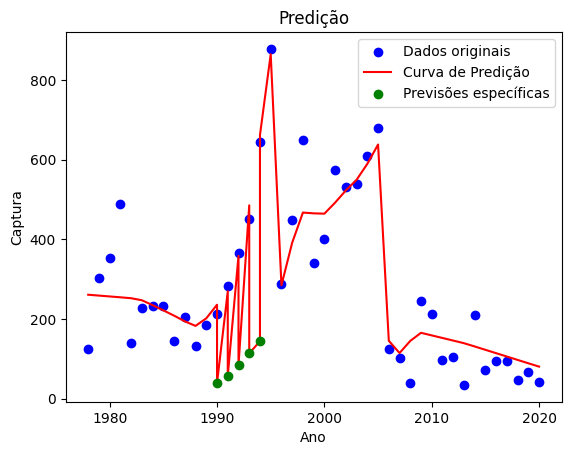

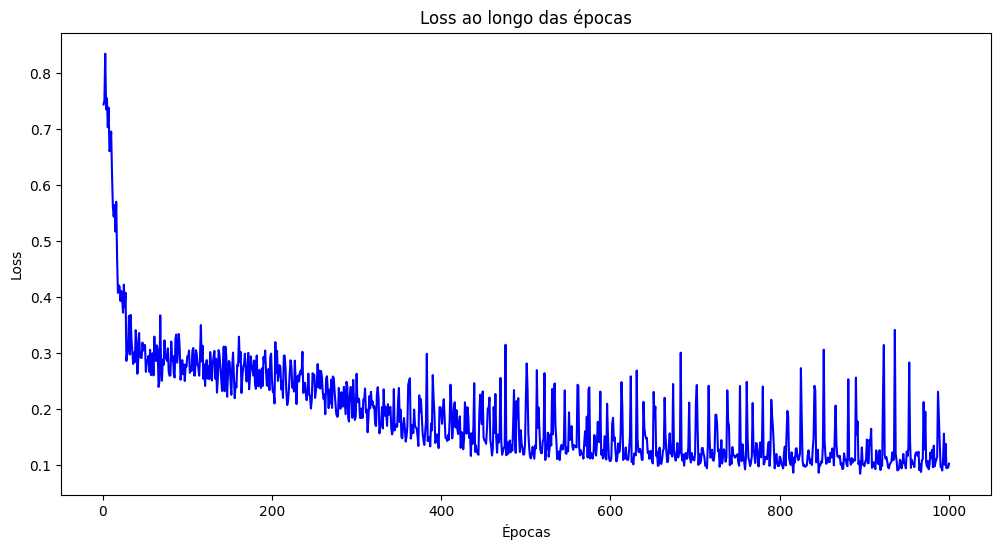

In [34]:
df_predicted = pd.DataFrame({'Ano': x.flatten(), 'Captura Original': y.flatten()})
df_all_predicted = pd.DataFrame({'Ano': x_all.flatten(), 'Captura Preditos': y_all_predicted.flatten()})
df_combined = pd.merge(df_predicted, df_all_predicted, on='Ano', how='outer').sort_values(by='Ano')

# Adicionando as previsões específicas aos dados combinados
df_anos_para_prever = pd.DataFrame({'Ano': anos_para_prever.flatten(), 'Captura Preditos': predicoes.flatten()})
df_combined = pd.concat([df_combined, df_anos_para_prever]).drop_duplicates().sort_values(by='Ano')

# Plotando os dados originais e as previsões
plt.scatter(df_combined['Ano'], df_combined['Captura Original'], color='blue', label='Dados originais')
plt.plot(df_combined['Ano'], df_combined['Captura Preditos'], color='red', label='Curva de Predição')
plt.scatter(df_anos_para_prever['Ano'], df_anos_para_prever['Captura Preditos'], color='green', label='Previsões específicas', zorder=5)
plt.xlabel('Ano')
plt.ylabel('Captura')
plt.title('Predição')
plt.legend()
plt.show()

# Plotando a perda ao longo das épocas
loss_values = history.history['loss']
epochs = range(1, len(loss_values) + 1)

plt.figure(figsize=(12, 6))
plt.plot(epochs, loss_values, 'b')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.title('Loss ao longo das épocas')
plt.show()